### Random forest

In [1]:
# Data Processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from imblearn.over_sampling import RandomOverSampler
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image

In [2]:
# Load Data
%store -r X_train X_test y_train y_test X_train_pca X_test_pca
%store -r koi_reduced_df reduced_df

no stored variable or alias X_train
no stored variable or alias X_test
no stored variable or alias y_train
no stored variable or alias y_test
no stored variable or alias X_train_pca
no stored variable or alias X_test_pca


In [3]:
X_train_pca = X_train_pca.copy()
X_test_pca = X_test_pca.copy()
X_train = X_train.copy()
X_test = X_test.copy()
y_train = y_train.copy()
y_test = y_test.copy()
print(y_train)
print(y_test)
print(X_train)
print(X_test)
print(X_train_pca)
print(X_test_pca)

NameError: name 'X_train_pca' is not defined

In [ ]:
# Random Forest
rf = RandomForestClassifier(n_estimators=10000,n_jobs = -1, random_state=1,class_weight='balanced') #参数根据需求调整
rf.fit(X_train_pca, y_train)

y_pred = rf.predict(X_test_pca)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.73


### Find the best parameter

In [ ]:
# use the random forest classifier to predict the test data
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_features = ['log2', 'sqrt']
max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]
min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)]
bootstrap = [True, False]
param_dist = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Create a random forest classifier
rf = RandomForestClassifier()
# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                param_dist, 
                        		n_iter = 100, 
                        		cv = 3, 
                        		verbose = 1, 
                        		n_jobs=-1, 
                        		random_state=0)
# Fit the random search object to the data
rand_search.fit(X_train_pca, y_train)
# Create a variable for the best model
best_rf = rand_search.best_estimator_
# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best hyperparameters: {'n_estimators': 700, 'min_samples_split': 12, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 13, 'bootstrap': False}


In [ ]:
# drop irrelevant columns
rs_df = pd.DataFrame(rand_search.cv_results_).sort_values('rank_test_score').reset_index(drop=True) 
rs_df = rs_df.drop([ 
            'mean_fit_time', 
            'std_fit_time', 
            'mean_score_time', 
            'std_score_time', 
            'params' , 
            'split0_test_score', 
            'split1_test_score', 
            'split2_test_score', 
            'std_test_score'], 
            axis=1) 
rs_df

,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,mean_test_score,rank_test_score
0,700,12,2,sqrt,13,False,0.711582,1
1,500,18,7,log2,7,True,0.710720,2
2,600,23,2,sqrt,15,False,0.709428,3
3,700,2,2,log2,11,True,0.706844,4
4,400,23,2,sqrt,14,False,0.705556,5
...,...,...,...,...,...,...,...,...
95,200,12,50,sqrt,1,False,0.652182,96
96,200,39,44,sqrt,1,True,0.651314,97
97,800,50,39,log2,1,True,0.650455,98
98,400,2,23,log2,1,False,0.649591,99


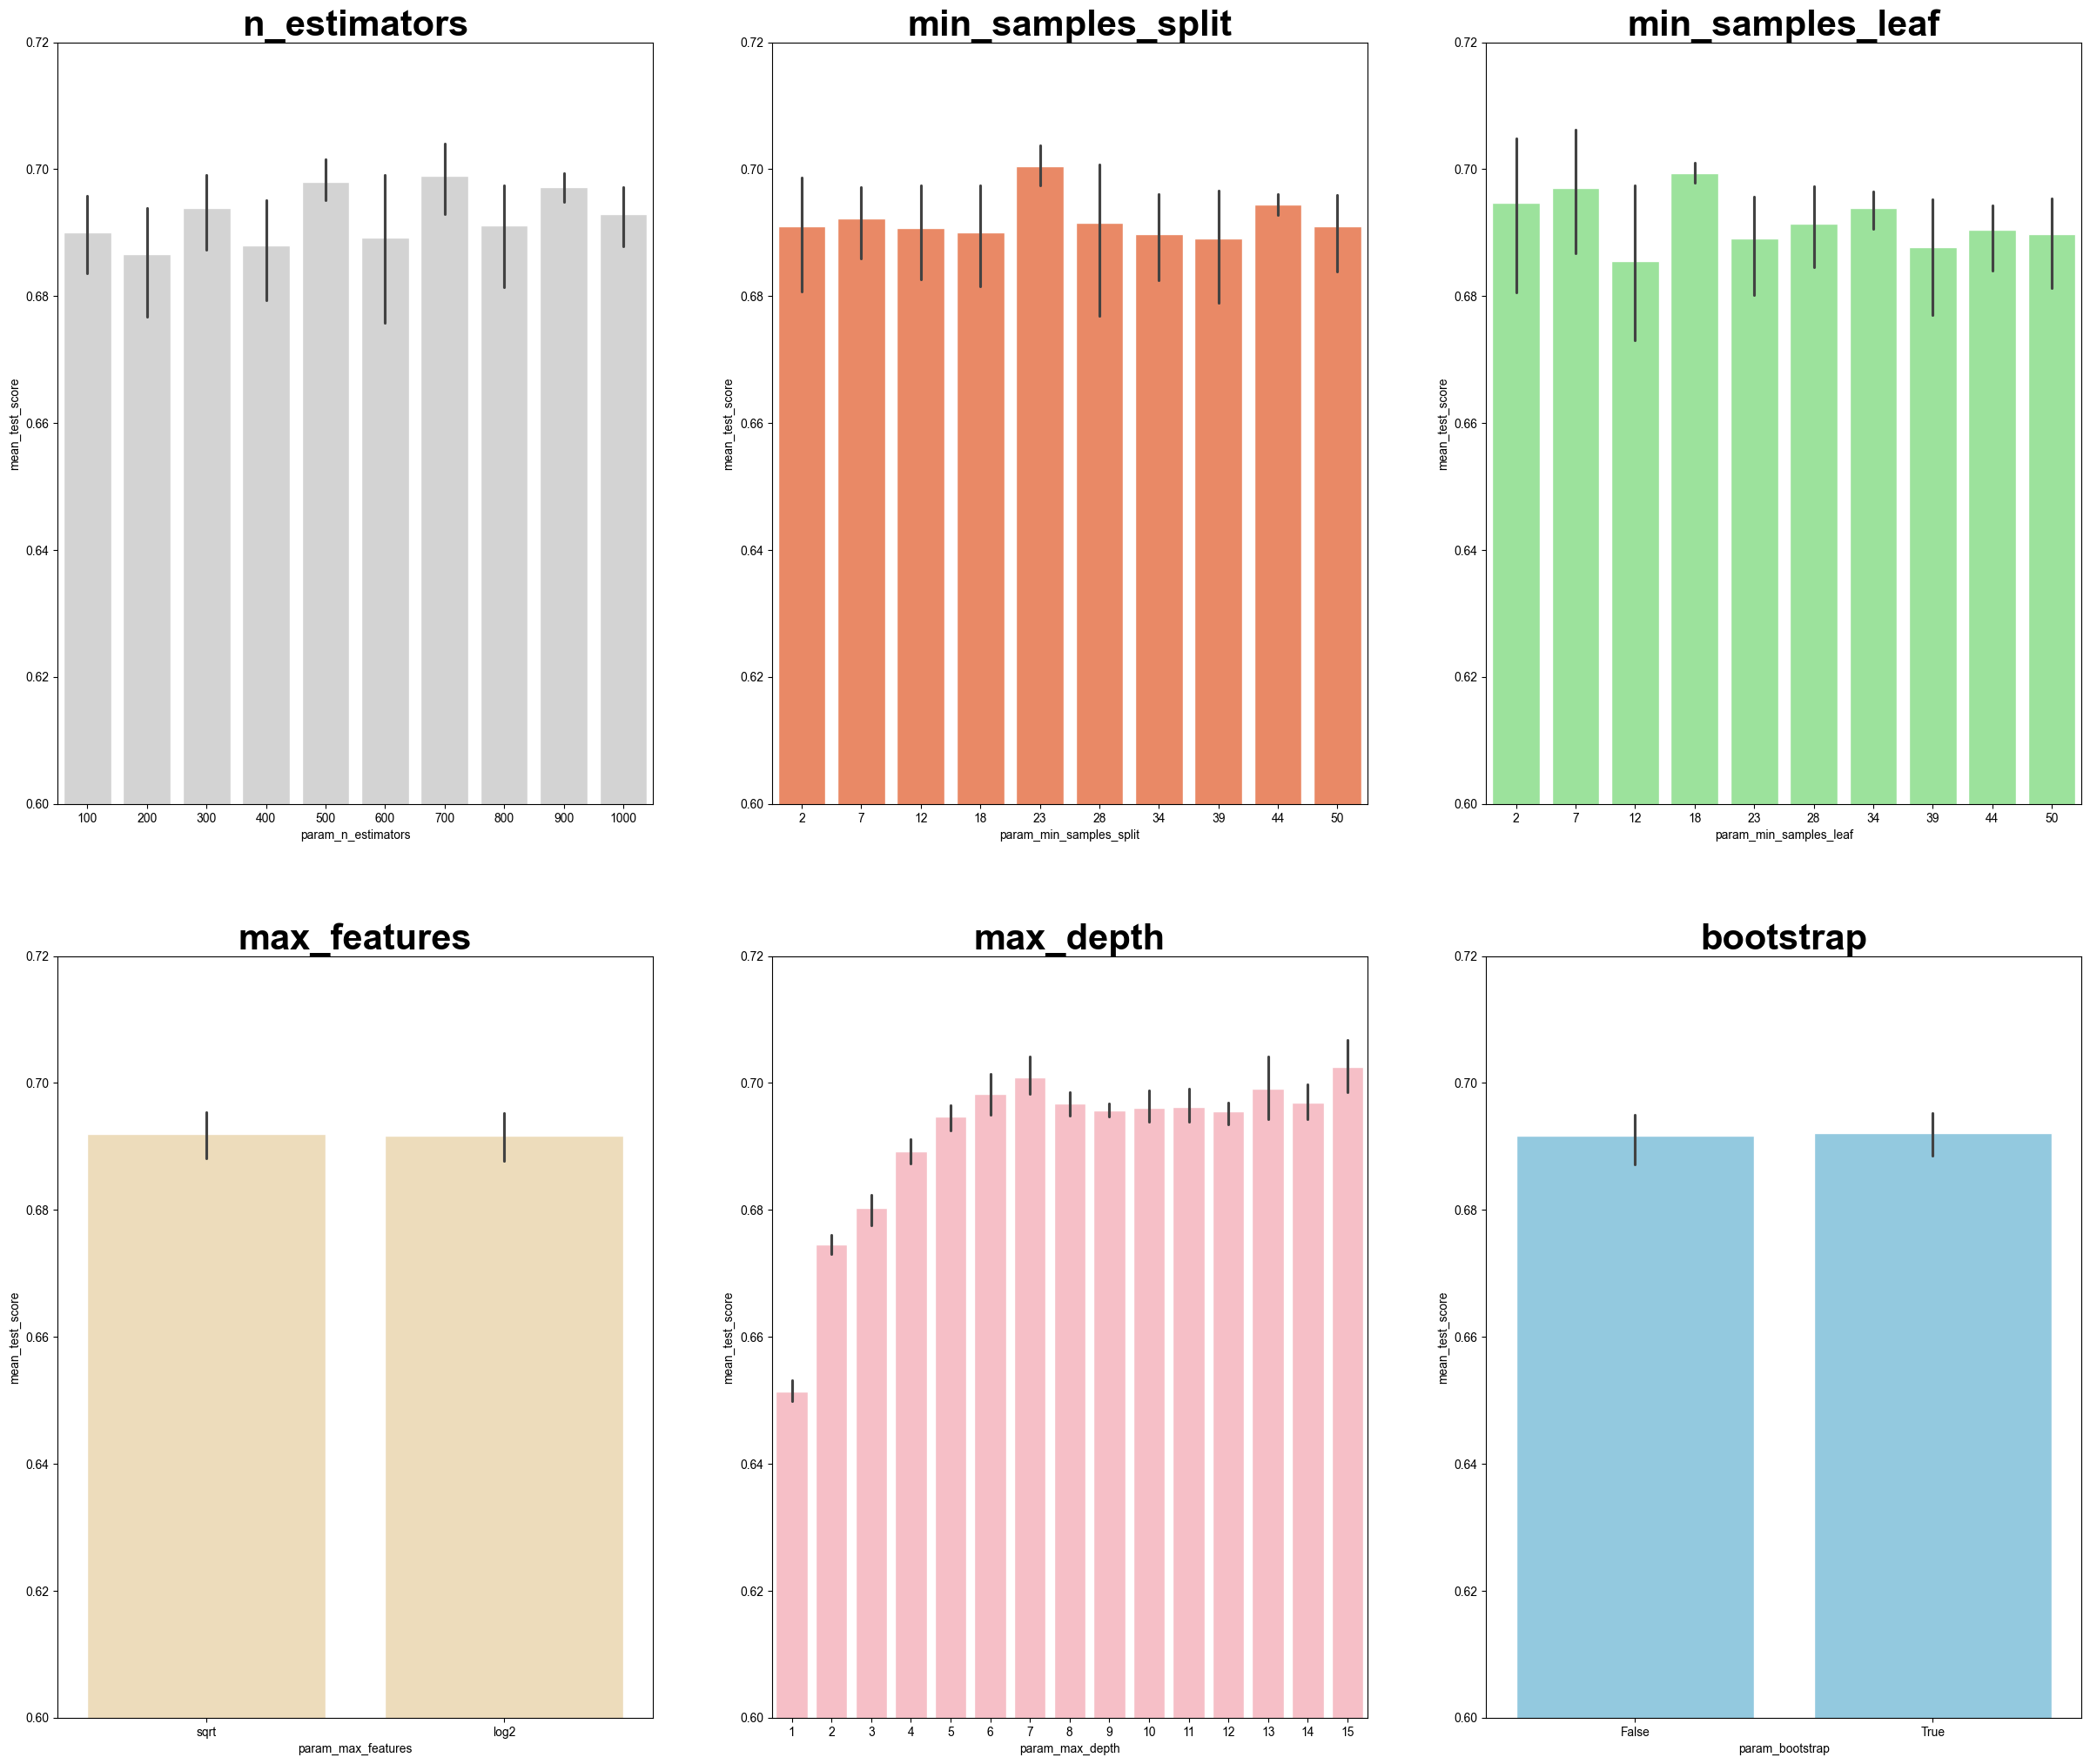

In [ ]:
# Plot the hyperparameters
fig, axs = plt.subplots(ncols=3, nrows=2)
sns.set(style="whitegrid", color_codes=True, font_scale = 2)
fig.set_size_inches(30,25)
sns.barplot(x='param_n_estimators', y='mean_test_score', data=rs_df, ax=axs[0,0], color='lightgrey')
axs[0,0].set_ylim([.60,.72]); axs[0,0].set_title(label = 'n_estimators', size=30, weight='bold')
sns.barplot(x='param_min_samples_split', y='mean_test_score', data=rs_df, ax=axs[0,1], color='coral')
axs[0,1].set_ylim([.60,.72]); axs[0,1].set_title(label = 'min_samples_split', size=30, weight='bold')
sns.barplot(x='param_min_samples_leaf', y='mean_test_score', data=rs_df, ax=axs[0,2], color='lightgreen')
axs[0,2].set_ylim([.60,.72]); axs[0,2].set_title(label = 'min_samples_leaf', size=30, weight='bold')
sns.barplot(x='param_max_features', y='mean_test_score', data=rs_df, ax=axs[1,0], color='wheat')
axs[1,0].set_ylim([.60,.72]); axs[1,0].set_title(label = 'max_features', size=30, weight='bold')
sns.barplot(x='param_max_depth', y='mean_test_score', data=rs_df, ax=axs[1,1], color='lightpink')
axs[1,1].set_ylim([.60,.72]); axs[1,1].set_title(label = 'max_depth', size=30, weight='bold')
sns.barplot(x='param_bootstrap',y='mean_test_score', data=rs_df, ax=axs[1,2], color='skyblue')
axs[1,2].set_ylim([.60,.72])
axs[1,2].set_title(label = 'bootstrap', size=30, weight='bold')
plt.show()

In [ ]:
# use grid search to find the best hyperparameters
from sklearn.model_selection import GridSearchCV
n_estimators = [500,700,900]
max_features = ['sqrt','log2']
max_depth = [6,7,15]
min_samples_split = [7,23,44,50]
min_samples_leaf = [2,7,18]
bootstrap = [True,False]
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
gs = GridSearchCV(rf, param_grid, cv = 3, verbose = 1, n_jobs=-1)
gs.fit(X_train_pca, y_train)
rfc_3 = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


{'bootstrap': False,
 'max_depth': 15,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 7,
 'n_estimators': 500}

In [ ]:
# predict the test data
y_pred_pca = rand_search.predict(X_test_pca) 
y_pred_gs = gs.best_estimator_.predict(X_test_pca)

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix_baseline_pca = pd.DataFrame(confusion_matrix(y_test, y_pred_pca), index = ['actual 0', 'actual 1','actual 2'], columns = ['predicted 0', 'predicted 1','predicted 2'])
conf_matrix_tuned_pca = pd.DataFrame(confusion_matrix(y_test, y_pred_gs), index = ['actual 0', 'actual 1','actual 2'], columns = ['predicted 0', 'predicted 1','predicted 2'])
display(conf_matrix_baseline_pca)
display(conf_matrix_tuned_pca)
display('Baseline Random Forest With PCA recall score', recall_score(y_test, y_pred_pca, average='weighted'))
display('Hyperparameter Tuned Random Forest With PCA Reduced Dimensionality recall score', recall_score(y_test, y_pred_gs, average='weighted'))

,predicted 0,predicted 1,predicted 2
actual 0,0,20,4
actual 1,0,523,416
actual 2,0,197,1164


,predicted 0,predicted 1,predicted 2
actual 0,1,19,4
actual 1,0,555,384
actual 2,0,223,1138


'Baseline Random Forest With PCA recall score'

0.7259036144578314

'Hyperparameter Tuned Random Forest With PCA Reduced Dimensionality recall score'

0.7289156626506024

In [ ]:
# F1 score
from sklearn.metrics import f1_score
f1 = f1_score(y_test, y_pred_gs, average='weighted') 
print("F1: ", f1)

F1:  0.7208595661361205


In [ ]:
# per class precision and recall
y_pred_proba = gs.best_estimator_.predict_proba(X_test_pca)
y_pred_proba_class2 = y_pred_proba[:, 2] 
y_test_binary = (y_test == 2).astype(int)
precision, recall, _ = precision_recall_curve(y_test_binary, y_pred_proba_class2)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='PR Curve for Class 2')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Class 2')
plt.legend()
plt.grid(True)
plt.show()

y_pred_proba_class1 = y_pred_proba[:, 1]
y_test_binary = (y_test == 1).astype(int)
precision, recall, _ = precision_recall_curve(y_test_binary, y_pred_proba_class1)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='PR Curve for Class 1')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Class 1')
plt.legend()
plt.grid(True)
plt.show()

y_pred_proba_class0 = y_pred_proba[:, 0]
y_test_binary = (y_test == 0).astype(int)
precision, recall, _ = precision_recall_curve(y_test_binary, y_pred_proba_class0)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label='PR Curve for Class 0')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Class 0')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'precision_recall_curve' is not defined

In [ ]:
# from imblearn.over_sampling import SMOTE
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA

# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# scaler = StandardScaler()
# X_train_resampled_scaled = scaler.fit_transform(X_train_resampled)
# X_test_scaled = scaler.transform(X_test)

# pca = PCA()
# pca.fit(X_train_resampled_scaled)
# explained = pca.explained_variance_ratio_
# cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)
# print(cumulative_explained_variance)
# # apply PCA to the training data
# pca = PCA(n_components=8)
# X_train_pca = pca.fit_transform(X_train_resampled_scaled)
# X_test_pca = pca.transform(X_test_scaled)

In [ ]:
# # Random Forest with PCA
# rf = RandomForestClassifier(n_estimators=10000,n_jobs = -1, random_state=1)
# rf.fit(X_train_pca, y_train_resampled)

# y_pred = rf.predict(X_test_pca)

# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy:.2f}")